In [1]:
import numpy as np
import terra

from meerkat.contrib.eeg import build_stanford_eeg_dp

from domino.emb.eeg import generate_words_dp, embed_words, embed_eeg
from domino.evaluate import run_sdms, score_sdm_explanations, score_sdms, run_sdm
from domino.sdm import MixtureModelSDM, SpotlightSDM
from domino.slices import collect_settings
from domino.train import score_settings, synthetic_score_settings, train_settings
from domino.utils import split_dp, balance_dp

import meerkat as mk
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, confusion_matrix, accuracy_score, roc_auc_score


/home/ksaab/Documents/meerkat/meerkat/nn/__init__.py:7: ExperimentalWarning: The `meerkat.nn` module is experimental and has limited test coverage. Proceed with caution.
  warnings.warn(


In [2]:
setting_dp = collect_settings.out(load=True)
setting_dp

,alpha (NumpyArrayColumn),build_setting_kwargs (ListColumn),dataset (PandasSeriesColumn),slice_category (PandasSeriesColumn),slice_names (ListColumn),target_name (PandasSeriesColumn),index (PandasSeriesColumn),setting_id (PandasSeriesColumn)
0,0.1,"{'target_frac': 0.5, 'error_rate': 0.1, 'n': 8000, 'attribute': 'age', 'attribute_thresh': 1}",eeg,noisy_label,['age<1'],sz,0,34694fdb-616b-4c11-8bf7-ac162982f47e
1,0.2,"{'target_frac': 0.5, 'error_rate': 0.2, 'n': 8000, 'attribute': 'age', 'attribute_thresh': 1}",eeg,noisy_label,['age<1'],sz,1,d610a10d-f1ca-4ee7-9765-5f07ea1aa9d6
2,0.3,"{'target_frac': 0.5, 'error_rate': 0.30000000000000004, 'n': 8000, 'attribute': 'age', 'attribute_thresh': 1}",eeg,noisy_label,['age<1'],sz,2,6a459eda-9c82-41f7-bc31-049cd4e01ca3
3,0.4,"{'target_frac': 0.5, 'error_rate': 0.4, 'n': 8000, 'attribute': 'age', 'attribute_thresh': 1}",eeg,noisy_label,['age<1'],sz,3,d79891a5-8462-420e-be5b-45b4d12eb1c5
4,0.5,"{'target_frac': 0.5, 'error_rate': 0.5, 'n': 8000, 'attribute': 'age', 'attribute_thresh': 1}",eeg,noisy_label,['age<1'],sz,4,02867608-b16b-435b-9bee-73086e577aba


In [3]:
run_sdms_dp = run_sdms.out(load=True)
run_sdms_dp.head()

,score_model_run_id (NumpyArrayColumn),setting_id (PandasSeriesColumn),build_setting_run_id (NumpyArrayColumn),score_settings_run_id (NumpyArrayColumn),synthetic_preds (NumpyArrayColumn),index (PandasSeriesColumn),alpha (NumpyArrayColumn),build_setting_kwargs (ListColumn),slice_names (ListColumn),dataset (PandasSeriesColumn),slice_category (PandasSeriesColumn),target_name (PandasSeriesColumn),run_sdm_run_id (PandasSeriesColumn),emb_group (PandasSeriesColumn),time_this_iter_s (PandasSeriesColumn),done (PandasSeriesColumn),timesteps_total (PandasSeriesColumn),episodes_total (PandasSeriesColumn),training_iteration (PandasSeriesColumn),experiment_id (PandasSeriesColumn),date (PandasSeriesColumn),timestamp (PandasSeriesColumn),time_total_s (PandasSeriesColumn),pid (PandasSeriesColumn),hostname (PandasSeriesColumn),node_ip (PandasSeriesColumn),time_since_restore (PandasSeriesColumn),timesteps_since_restore (PandasSeriesColumn),iterations_since_restore (PandasSeriesColumn),trial_id (PandasSeriesColumn),sdm_config/weight_y_log_likelihood (PandasSeriesColumn),sdm_config/n_clusters (PandasSeriesColumn),sdm_config/n_slices (PandasSeriesColumn),sdm_config/emb (PandasSeriesColumn),sdm_config/xmodal_emb (PandasSeriesColumn),config/sdm (PandasSeriesColumn),config/slice (PandasSeriesColumn),logdir (PandasSeriesColumn),sdm_config/learning_rate (PandasSeriesColumn),sdm_class (PandasSeriesColumn)
0,3642,0b948434-c4c4-4b60-8b60-1fa9a69d712d,3642,3641,True,0,0.0,"{'correlate': 'age', 'corr': 0.0, 'correlate_threshold': 1, 'n': 8000}","['sz=0_age>1', 'sz=1_age<1']",eeg,correlation,sz,3672,eeg,2.747292,False,NaN,NaN,1,bfbe94ca5e9b4c3f8b90797a841a66c6,2021-09-30_13-01-31,1633032091,2.747292,6928,gemini1,171.65.28.88,2.747292,0,1,2c25b_00000,10.0,10.0,10,emb,emb,"{'sdm_class': '', 'sdm_config': {'emb': ['eeg', 'emb'], 'learning_rate': None, 'n_clusters': 10.0, 'n_slices': 10, 'weight_y_log_likelihood': 10.0, 'xmodal_emb': 'emb'}}","{'alpha': 0.0, 'build_setting_kwargs': {'attribute': None, 'attribute_thresh': None, 'corr': 0.0, 'correlate': 'age', 'correlate_threshold': 1.0, 'error_rate': None, 'n': 8000, 'slice_frac': None, 'target_frac': None}, 'build_setting_run_id': 3642, 'dataset': 'eeg', 'index': '0', 'score_model_run_id': 3642, 'score_settings_run_id': 3641, 'setting_id': '0b948434-c4c4-4b60-8b60-1fa9a69d712d', 'slice_category': 'correlation', 'slice_names': ['sz=0_age>1', 'sz=1_age<1'], 'synthetic_preds': 'True', 'target_name': 'sz'}","/media/4tb_hdd/terra/slice/tasks/evaluate/run_sdms/_runs/3667/_evaluate_2021-09-30_13-01-17/_evaluate_2c25b_00000_0_sdm={'sdm_class': , 'sdm_config': {'weight_y_log_likelihood': 10, _2021-09-30_13-01-17",NaN,domino.sdm.gmm.MixtureModelSDM
1,3642,0b948434-c4c4-4b60-8b60-1fa9a69d712d,3642,3641,True,1,0.0,"{'correlate': 'age', 'corr': 0.0, 'correlate_threshold': 1, 'n': 8000}","['sz=0_age>1', 'sz=1_age<1']",eeg,correlation,sz,3668,multimodal,3.326482,False,NaN,NaN,1,0626e99e9f6f4626a00ce4ca41b783af,2021-09-30_13-01-32,1633032092,3.326482,6925,gemini1,171.65.28.88,3.326482,0,1,2c25b_00001,10.0,10.0,10,emb,emb,"{'sdm_class': '', 'sdm_config': {'emb': ['multimodal', 'emb'], 'learning_rate': None, 'n_clusters': 10.0, 'n_slices': 10, 'weight_y_log_likelihood': 10.0, 'xmodal_emb': 'emb'}}","{'alpha': 0.0, 'build_setting_kwargs': {'attribute': None, 'attribute_thresh': None, 'corr': 0.0, 'correlate': 'age', 'correlate_threshold': 1.0, 'error_rate': None, 'n': 8000, 'slice_frac': None, 'target_frac': None}, 'build_setting_run_id': 3642, 'dataset': 'eeg', 'index': '0', 'score_model_run_id': 3642, 'score_settings_run_id': 3641, 'setting_id': '0b948434-c4c4-4b60-8b60-1fa9a69d712d', 'slice_category': 'correlation', 'slice_names': ['sz=0_age>1', 'sz=1_age<1'], 'synthetic_preds': 'True', 'target_name': 'sz'}","/media/4tb_hdd/terra/slice/tasks/evaluate/run_sdms/_runs/3667/_evaluate_2021-09-30_13-01-17/_evaluate_2c25b_00001_1_sdm={'sdm_class': , 'sdm_config': {'weight_y_log_likelihood': 10, _2021-09-30_13-01-17",NaN,domino.sdm.gmm

In [4]:
score_dp = mk.DataPanel.from_pandas(score_sdms.out(load=True))
score_dp

,pred_slice_idx (PandasSeriesColumn),slice_idx (PandasSeriesColumn),auroc (PandasSeriesColumn),precision_at_10 (PandasSeriesColumn),precision_at_25 (PandasSeriesColumn),precision_at_100 (PandasSeriesColumn),recall_at_50 (PandasSeriesColumn),recall_at_100 (PandasSeriesColumn),recall_at_200 (PandasSeriesColumn),recall (PandasSeriesColumn),precision (PandasSeriesColumn),target_name (PandasSeriesColumn),run_sdm_run_id (PandasSeriesColumn),slice_name (PandasSeriesColumn),index (PandasSeriesColumn)
0,0.0,0.0,0.065443,0.0,0.00,0.00,0.0,0.000000,0.000000,0.000000,0.000000,sz,3672.0,sz=0_age>1,0
1,1.0,0.0,0.111596,0.0,0.00,0.00,0.0,0.000000,0.000000,0.000000,0.000000,sz,3672.0,sz=0_age>1,1
2,2.0,0.0,0.873620,0.3,0.40,0.53,0.0,0.277778,0.550505,0.393939,0.523490,sz,3672.0,sz=0_age>1,2
3,3.0,0.0,0.191967,0.0,0.00,0.00,0.0,0.000000,0.000000,0.000000,0.000000,sz,3672.0,sz=0_age>1,3
4,4.0,0.0,0.855045,0.2,0.24,0.29,0.0,0.176768,0.343434,0.227273,0.323741,sz,3672.0,sz=0_age>1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,5.0,0.0,0.500000,0.5,0.32,0.22,0.0,0.000000,0.000000,0.000000,0.000000,sz,3903.0,age<1,3495
3496,6.0,0.0,0.500000,0.5,0.32,0.22,0.0,0.000000,0.000000,0.000000,0.000000,sz,3903.0,age<1,3496
3497,7.0,0.0,0.500000,0.5,0.32,0.22,0.0,0.000000,0.000000,0.000000,0.000000,sz,3903.0,age<1,3497
3498,8.0,0.0,0.500000,0.5,0.32,0.22,0.0,0.000000,0.000000,0.000000,0.000000,sz,3903.0,age<1,3498


In [5]:
results_dp = mk.merge(
    score_dp,
    run_sdms_dp["sdm_class", "config/sdm", "alpha", "run_sdm_run_id", "build_setting_kwargs", "slice_category"], # include any other columns here you'd like to analyze
    on="run_sdm_run_id"
)
emb_col = results_dp["config/sdm"].map(lambda x: x["sdm_config"]["emb"][0])
results_dp["emb_type"] = emb_col

corr_thresh_col = results_dp["build_setting_kwargs"].map(lambda x: x["correlate_threshold"] if "correlate_threshold" in x else x["attribute_thresh"])
results_dp["corr_thresh"] = corr_thresh_col


results_df = results_dp.to_pandas()
results_df

,run_sdm_run_id,pred_slice_idx,slice_idx,auroc,precision_at_10,precision_at_25,precision_at_100,recall_at_50,recall_at_100,recall_at_200,...,target_name,slice_name,index,sdm_class,config/sdm,alpha,build_setting_kwargs,slice_category,emb_type,corr_thresh
0,3672,0,0,0.065443,0.0,0.00,0.00,0.0,0.000000,0.000000,...,sz,sz=0_age>1,0,domino.sdm.gmm.MixtureModelSDM,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.0,"{'correlate': 'age', 'corr': 0.0, 'correlate_t...",correlation,eeg,1
1,3672,1,0,0.111596,0.0,0.00,0.00,0.0,0.000000,0.000000,...,sz,sz=0_age>1,1,domino.sdm.gmm.MixtureModelSDM,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.0,"{'correlate': 'age', 'corr': 0.0, 'correlate_t...",correlation,eeg,1
2,3672,2,0,0.873620,0.3,0.40,0.53,0.0,0.277778,0.550505,...,sz,sz=0_age>1,2,domino.sdm.gmm.MixtureModelSDM,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.0,"{'correlate': 'age', 'corr': 0.0, 'correlate_t...",correlation,eeg,1
3,3672,3,0,0.191967,0.0,0.00,0.00,0.0,0.000000,0.000000,...,sz,sz=0_age>1,3,domino.sdm.gmm.MixtureModelSDM,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.0,"{'correlate': 'age', 'corr': 0.0, 'correlate_t...",correlation,eeg,1
4,3672,4,0,0.855045,0.2,0.24,0.29,0.0,0.176768,0.343434,...,sz,sz=0_age>1,4,domino.sdm.gmm.MixtureModelSDM,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.0,"{'correlate': 'age', 'corr': 0.0, 'correlate_t...",correlation,eeg,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3903,5,0,0.500000,0.5,0.32,0.22,0.0,0.000000,0.000000,...,sz,age<1,3495,domino.sdm.confusion.ConfusionSDM,{'sdm_class': '<class 'domino.sdm.confusion.Co...,0.5,"{'target_frac': 0.5, 'error_rate': 0.5, 'n': 8...",noisy_label,multimodal,1
3496,3903,6,0,0.500000,0.5,0.32,0.22,0.0,0.000000,0.000000,...,sz,age<1,3496,domino.sdm.confusion.ConfusionSDM,{'sdm_class': '<class 'domino.sdm.confusion.Co...,0.5,"{'target_frac': 0.5, 'error_rate': 0.5, 'n': 8...",noisy_label,multimodal,1
3497,3903,7,0,0.500000,0.5,0.32,0.22,0.0,0.000000,0.000000,...,sz,age<1,3497,domino.sdm.confusion.ConfusionSDM,{'sdm_class': '<class 'domino.sdm.confusion.Co...,0.5,"{'target_frac': 0.5, 'error_rate': 0.5, 'n': 8...",noisy_label,multimodal,1
3498,3903,8,0,0.500000,0.5,0.32,0.22,0.0,0.000000,0.000000,...,sz,age<1,3498,domino.sdm.confusion.ConfusionSDM,{'sdm_class': '<class 'domino.sdm.confusion.Co...,0.5,"{'target_frac': 0.5, 'error_rate': 0.5, 'n': 8...",noisy_label,multimodal,1


<ipython-input-6-0335ade20499>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df["success"] = grouped_df["precision_at_10"] > 0.6


350


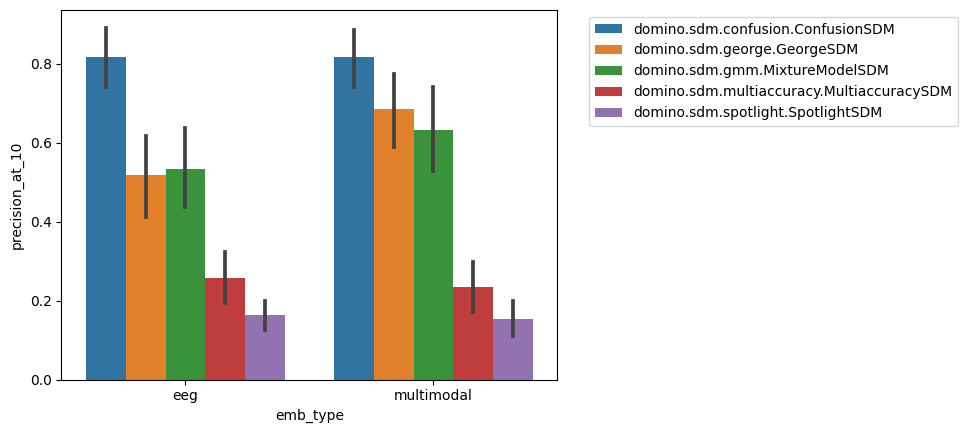

In [6]:
metric = "precision_at_10"
grouped_df = results_df.iloc[results_df.reset_index().groupby(["sdm_class", "slice_name", "slice_idx","emb_type", "alpha", "corr_thresh", "slice_category"])[metric].idxmax().astype(int)]

grouped_df["success"] = grouped_df["precision_at_10"] > 0.6

print(len(grouped_df))
#ax = sns.lineplot(data=grouped_df,x="alpha",y=metric, hue="emb_type",style="slice_name")
#ax = sns.violinplot(data=grouped_df,x=metric,y="emb_type")
ax = sns.barplot(data=grouped_df,y=metric,x="emb_type",hue="sdm_class")
#ax = sns.displot(data=grouped_df,x=metric,hue="sdm_class")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


In [7]:
# metric = "auroc"
# grouped_df = results_df.iloc[results_df.reset_index().groupby(["sdm_class", "slice_name", "slice_idx","emb_type","alpha","corr_thresh"])[metric].idxmax().astype(int)]


# #ax = sns.lineplot(data=grouped_df,x="alpha",y=metric, hue="emb_type",style="slice_name")
# ax = sns.barplot(data=grouped_df,x=metric,y="slice_category",hue="sdm_class")
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()

In [8]:
specific_run = grouped_df[grouped_df["emb_type"]=="multimodal"][grouped_df["slice_idx"]==0][grouped_df["alpha"]==0][grouped_df["sdm_class"]=="domino.sdm.confusion.ConfusionSDM"]
specific_run

<ipython-input-8-2102573fa2db>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  specific_run = grouped_df[grouped_df["emb_type"]=="multimodal"][grouped_df["slice_idx"]==0][grouped_df["alpha"]==0][grouped_df["sdm_class"]=="domino.sdm.confusion.ConfusionSDM"]


,run_sdm_run_id,pred_slice_idx,slice_idx,auroc,precision_at_10,precision_at_25,precision_at_100,recall_at_50,recall_at_100,recall_at_200,...,slice_name,index,sdm_class,config/sdm,alpha,build_setting_kwargs,slice_category,emb_type,corr_thresh,success
181,3678,1,0,0.965169,1.0,1.0,0.86,0.232323,0.434343,0.752525,...,sz=0_age>1,181,domino.sdm.confusion.ConfusionSDM,{'sdm_class': '<class 'domino.sdm.confusion.Co...,0.0,"{'correlate': 'age', 'corr': 0.0, 'correlate_t...",correlation,multimodal,1,True


In [9]:
sdm_dp, _ = run_sdm.out(specific_run["run_sdm_run_id"].values[0],load=True)
sdm_dp.head()

,id (PandasSeriesColumn),file_id (PandasSeriesColumn),age (NumpyArrayColumn),fm_split (PandasSeriesColumn),sz_start_index (NumpyArrayColumn),index (PandasSeriesColumn),filepath (PandasSeriesColumn),input (LambdaColumn),target (NumpyArrayColumn),duration (NumpyArrayColumn),binarized_age (NumpyArrayColumn),slices (NumpyArrayColumn),split (PandasSeriesColumn),probs (TensorColumn),pred_slices (NumpyArrayColumn),emb (NumpyArrayColumn)
0,CA0555UV_1-1+_-1.0,CA0555UV_1-1+,4.231505,train,-1.0,33366,/media/4tb_hdd/eeg_data/lpch/lpch/CA0555UV_1-1+.eeghdf,"LambdaCell(fn=functools.partial(, clip_len=12))",False,569.0,1,"np.ndarray(shape=(2,))",test,torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(10,))","np.ndarray(shape=(128,))"
1,DA0550HM_1-1+_-1.0,DA0550HM_1-1+,0.005981,train,-1.0,15431,/media/4tb_hdd/eeg_data/lpch/lpch/DA0550HM_1-1+.eeghdf,"LambdaCell(fn=functools.partial(, clip_len=12))",False,2563.0,0,"np.ndarray(shape=(2,))",test,torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(10,))","np.ndarray(shape=(128,))"
2,DA05501R_1-12+_-1.0,DA05501R_1-12+,0.015917,train,-1.0,43658,/media/4tb_hdd/eeg_data/lpch/lpch/DA05501R_1-12+.eeghdf,"LambdaCell(fn=functools.partial(, clip_len=12))",False,344.0,0,"np.ndarray(shape=(2,))",test,torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(10,))","np.ndarray(shape=(128,))"
3,CA75509Z_1-10+_0.0,CA75509Z_1-10+,0.122365,train,0.0,2286,/media/4tb_hdd/eeg_data/lpch/lpch/CA75509Z_1-10+.eeghdf,"LambdaCell(fn=functools.partial(, clip_len=12))",True,358.0,0,"np.ndarray(shape=(2,))",test,torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(10,))","np.ndarray(shape=(128,))"
4,CA7550UA_1-3+_0.0,CA7550UA_1-3+,21.535599,train,0.0,9280,/media/4tb_hdd/eeg_data/stanford/stanford_mini/CA7550UA_1-3+.eeghdf,"LambdaCell(fn=functools.partial(, clip_len=12))",True,421.0,1,"np.ndarray(shape=(2,))",test,torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(10,))","np.ndarray(shape=(128,))"


In [10]:
from domino.slices.abstract import build_setting

specific_run = grouped_df[grouped_df["emb_type"]=="multimodal"][grouped_df["slice_idx"]==0][grouped_df["alpha"]==0][grouped_df["sdm_class"]=="domino.sdm.confusion.ConfusionSDM"]
sdm_dp, _ = run_sdm.out(specific_run["run_sdm_run_id"].values[0],load=True)

preds = np.array(sdm_dp.lz["probs"].argmax(1))
targets = np.array(sdm_dp.lz["target"])
in_slice = sdm_dp.lz["slices"][:,0]

print(targets.mean())
tn, fp, fn, tp = confusion_matrix(targets,preds,normalize="true").ravel()
print(f"FP: {fp}, FN: {fn}")

pred_slices = sdm_dp.lz["pred_slices"]
#for ndx in range(10):
ndx=1
pp = pred_slices[:,ndx]
pp = (targets==0)*np.array(sdm_dp.lz["probs"][:,1]>0.5)
#print(roc_auc_score(in_slice,pp))
print(precision_score(in_slice,pp))

#print((preds != targets).mean())
#print((preds[in_slice]!= targets[in_slice]).mean())
fns = np.array((targets==0)*(preds==1))
print(in_slice[fns].mean())

#synth_dp.head()

0.6524017467248908
FP: 0.4020100502512563, FN: 0.36947791164658633
0.78125
0.78125


<ipython-input-10-6ef34ff161e5>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  specific_run = grouped_df[grouped_df["emb_type"]=="multimodal"][grouped_df["slice_idx"]==0][grouped_df["alpha"]==0][grouped_df["sdm_class"]=="domino.sdm.confusion.ConfusionSDM"]


In [11]:
pred_slices.argmax(1).min()

0

In [12]:
# grouped_df["success"] = np.logical_and(grouped_df["auroc"] > 0.7, grouped_df["precision_at_10"] > 0.4)

# #ax = sns.pointplot(data=grouped_df,x="alpha",y="success", hue="emb_type", dodge=True, join=False)
# ax = sns.barplot(data=grouped_df,x="success",y="emb_type")

# plt.show()

# Explanations

In [13]:
words_dp = embed_words.out(load=True)

# get multimodal sdm run ids
slice_id = 0
alpha = 0.8

specific_run = grouped_df[grouped_df["emb_type"]=="multimodal"][grouped_df["slice_idx"]==slice_id][grouped_df["alpha"]==alpha]
specific_run

<ipython-input-13-32d934545db8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  specific_run = grouped_df[grouped_df["emb_type"]=="multimodal"][grouped_df["slice_idx"]==slice_id][grouped_df["alpha"]==alpha]


,run_sdm_run_id,pred_slice_idx,slice_idx,auroc,precision_at_10,precision_at_25,precision_at_100,recall_at_50,recall_at_100,recall_at_200,...,slice_name,index,sdm_class,config/sdm,alpha,build_setting_kwargs,slice_category,emb_type,corr_thresh,success
1981,3752,1,0,0.956422,0.6,0.56,0.26,0.484848,0.787879,0.969697,...,sz=0_age>1,1981,domino.sdm.confusion.ConfusionSDM,{'sdm_class': '<class 'domino.sdm.confusion.Co...,0.8,"{'correlate': 'age', 'corr': 0.8, 'correlate_t...",correlation,multimodal,1,False
1941,3750,1,0,0.935640,0.3,0.24,0.19,0.303030,0.575758,0.969697,...,sz=0_age>1,1941,domino.sdm.george.GeorgeSDM,{'sdm_class': '<class 'domino.sdm.george.Georg...,0.8,"{'correlate': 'age', 'corr': 0.8, 'correlate_t...",correlation,multimodal,1,False
1824,3744,4,0,0.845805,0.3,0.12,0.09,0.090909,0.272727,0.545455,...,sz=0_age>1,1824,domino.sdm.gmm.MixtureModelSDM,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.8,"{'correlate': 'age', 'corr': 0.8, 'correlate_t...",correlation,multimodal,1,False
1900,3748,0,0,0.563109,0.0,0.00,0.02,0.030303,0.060606,0.151515,...,sz=0_age>1,1900,domino.sdm.multiaccuracy.MultiaccuracySDM,{'sdm_class': '<class 'domino.sdm.multiaccurac...,0.8,"{'correlate': 'age', 'corr': 0.8, 'correlate_t...",correlation,multimodal,1,False
1860,3817,0,0,0.507018,0.0,0.04,0.05,0.030303,0.030303,0.030303,...,sz=0_age>1,1860,domino.sdm.spotlight.SpotlightSDM,{'sdm_class': '<class 'domino.sdm.spotlight.Sp...,0.8,"{'correlate': 'age', 'corr': 0.8, 'correlate_t...",correlation,multimodal,1,False


In [14]:
pred_slice_idx = specific_run["pred_slice_idx"].values[0]
_, expl_dp = run_sdm.out(specific_run["run_sdm_run_id"].values[0],load=True)
expl_dp[(-expl_dp["pred_slices"].data[:,pred_slice_idx]).argsort()][:10]

,word (PandasSeriesColumn),pred_slices (NumpyArrayColumn)
0,"o stroke, dementia, p/w pleural effusion s/p VATS, PEG c/b septic peritonitis; decreased responsiveness, clonic movements, evaluation for seizures.","np.ndarray(shape=(10,))"
1,"Hom, Jason L, MD History: 89 year-old man with history of multiple medical problems including likely vascular dementia, heart failure, chronic kidney disease, DM, chronic atrial fibrillation status post pacemaker placement, hyponatremia, chronic subdural hematoma s/p craniotomy, and recent admission for klebsiella UTI and pneumonia who is admitted with altered mental status.","np.ndarray(shape=(10,))"
2,"NEUT, % 71.8 LYM, % 14.1 MONO, % 11.4 EOS, % 0.8 BASO, % 1.9 NEUT, ABS 2.91","np.ndarray(shape=(10,))"
3,"NYHA III presented to OSH with volume overload and HF symptoms, found to be in low output HF with EF 8% requiring inotrope support.","np.ndarray(shape=(10,))"
4,Ser/Plas 91 70 - 100,"np.ndarray(shape=(10,))"
5,"77 mEq/L 1,000 mL IV solution, 40 mL/hr; DOPamine 3.2 mg","np.ndarray(shape=(10,))"
6,Ser/Plas 93 70 - 100,"np.ndarray(shape=(10,))"
7,"dialysate soln, 5,000 mL | sodium bicarbonate, 50 mEq | sodium chloride 0.9 %, 5 mL | sodium chloride","np.ndarray(shape=(10,))"
8,| leucovorin | levothyroxine | melatonin | metroNIDAZOLE | NAMENDA,"np.ndarray(shape=(10,))"
9,"History: 59 year old M with h/o CAD, s/p MVA , and a long hospital course including anuric renal failure, STEMI, DVT, and infection.","np.ndarray(shape=(10,))"


In [15]:
expl_dp[(-expl_dp["pred_slices"].data[:,pred_slice_idx]).argsort()][10:20]

,word (PandasSeriesColumn),pred_slices (NumpyArrayColumn)
0,"Facility-Administered Medications: acetaminophen, 325 mg | dextrose 5% and 0.9% NaCl with KCl 20 mEq/L, | LORazepam, 0.1 mg/kg (Dosing Weight)","np.ndarray(shape=(10,))"
1,"/hr | sodium chloride 0.9%, 5 mL/hr | sodium chloride 3%, 5 mL | spironolactone, 1 mg/kg (Dosing Weight)","np.ndarray(shape=(10,))"
2,"Facility-Administered Medications: acetaminophen, 120 mg | dextrose 5% and 0.9% NaCl with KCl 20 mEq/L, | nystatin,","np.ndarray(shape=(10,))"
3,"/b MICU stay for septic shock with LLL consolidations, anasarca and persistent delirium, now with new headache.""","np.ndarray(shape=(10,))"
4,"Continuous Infusion: DOPamine, DOPamine drip, Dextrose 5% with 0.9% NaCl and KCl 20 mEq/l, EPINEPHrine, Dextrose 5% in Water, Sodium Chloride 0.9%, Sodium Chloride","np.ndarray(shape=(10,))"
5,"mEq/mL inj (Central line only) 2.68 mEq, 1 mEq/kg (Dosing Weight); sodium bicarbonate 4.2 % extemp inj","np.ndarray(shape=(10,))"
6,"Continuous Infusion: DOPamine, DOPamine drip, Dextrose 5% with 0.9% NaCl and KCl 20 mEq/","np.ndarray(shape=(10,))"
7,"(1 mEq/L) 5,000 mL CRRT solution, 5,000 mL; sodium bicarbonate 4.6 mEq in sterile water (PF)","np.ndarray(shape=(10,))"
8,"Facility-Administered Medications: acetaminophen, 240 mg | dextrose 5% and 0.9% NaCl with KCl 20 mEq/L, | LORazepam, 0.1 mg/kg (Dosing Weight)","np.ndarray(shape=(10,))"
9,", 100 mg/kg (Dosing Weight); dextrose 5 %-0.9 % NaCl with KCl 20 mEq/L infusion, ; heparin, porcine (","np.ndarray(shape=(10,))"


In [18]:
from domino.plot import sdm_barplot, sdm_displot
sdm_barplot(
    score_sdm_ids=[3918],
    emb_groups=["eeg", "multimodal"],
    sdm_classes=["domino.sdm.gmm.MixtureModelSDM"],
)
# sdm_barplot(
#     score_sdm_ids=[3918],
#     emb_groups=["multimodal"],
#     sdm_classes=["domino.sdm.gmm.MixtureModelSDM", "domino.sdm.multiaccuracy.MultiaccuracySDM"],
# )
plt.show()

sdm_displot(
    score_sdm_ids=[3918],
    emb_groups=["eeg", "multimodal"],
    sdm_classes=["domino.sdm.gmm.MixtureModelSDM"],
)
plt.show()

ImportError: cannot import name 'sdm_displot' from 'domino.plot' (/home/ksaab/Documents/domino/domino/plot.py)